# [Assignment 2](https://ovgu-ailab.github.io/idl2023/assignment2.html)

**_Colaborative Work from Adrian Bremer and Philipp Reinig_**

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-10-24 13:41:41.805718: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-24 13:41:41.963199: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 13:41:41.963259: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 13:41:41.963974: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 13:41:42.025709: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-24 13:41:42.027380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## MLP from assignment 1

In [2]:
class MLP:
    
    def __init__(self, layer_sizes, init_val):
        if len(layer_sizes) <= 1:
            raise AssertionError("There has to be at least 2 layers. 'layer_sizes' was {}".format(layer_sizes))
        
        self.weights = [tf.Variable(np.random.uniform(low=-init_val, high=init_val, size=(layer_sizes[i], layer_sizes[i+1])).astype(np.float32)) for i in range(len(layer_sizes)-1)]
        self.biases = [tf.Variable(np.zeros(layer_sizes[i]).astype(np.float32)) for i in range(1,len(layer_sizes))]
    
    def model(self, input_batch):
        """returns the logits for a given input batch"""
        
        n = len(self.biases)
        if n == 1:
            return tf.matmul(input_batch, self.weights[0]) + self.biases[0]
        
        next_input = input_batch
        for i in range(n-1):
            next_input = tf.nn.leaky_relu(tf.matmul(next_input, self.weights[i]) + self.biases[i])
        
        return tf.matmul(next_input, self.weights[n-1]) + self.biases[n-1]
    
    def train(self, imgs, lbls, learning_rate):
        """returns the cross entropy error"""
        n = len(self.biases)
      
        with tf.GradientTape() as tape:
            logits = self.model(imgs)
            xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits, labels=lbls))
        
        grads = tape.gradient(xent, self.weights + self.biases)
        for i in range(n):
            self.weights[i].assign_sub(learning_rate * grads[i])
            self.biases[i].assign_sub(learning_rate * grads[n+i])
        
        return xent
            
            

## Datasets
### Shuffle, batch, repeat

- **shuffle** - reorders the dataset uniformly at random
- **batch** - produces a dataset that has batches
- **repeat** - repeats the dataset the given amount of times or indefinitly -> when the dataset ends it wraps around

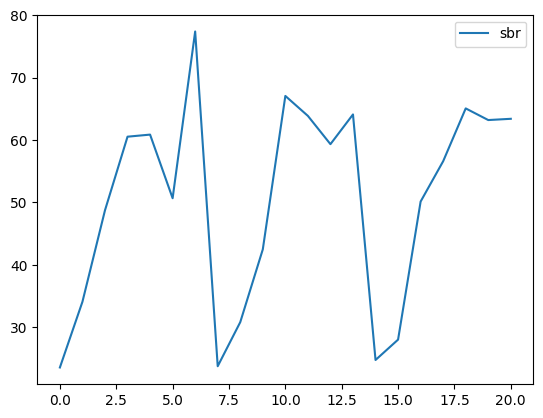

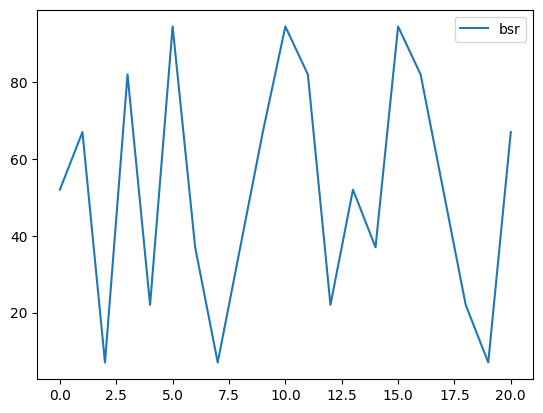

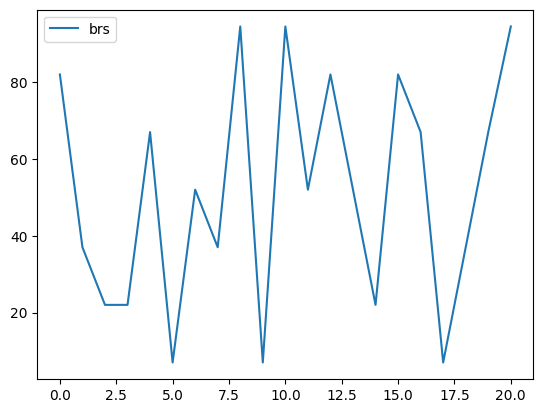

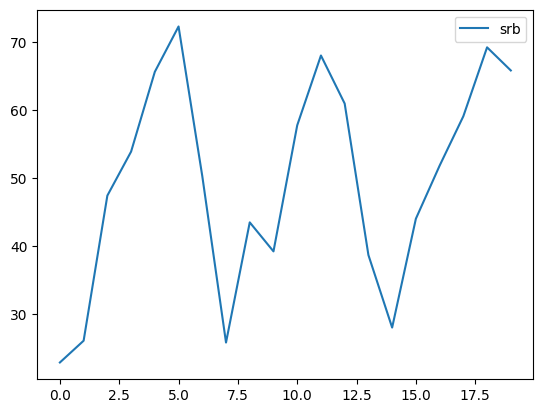

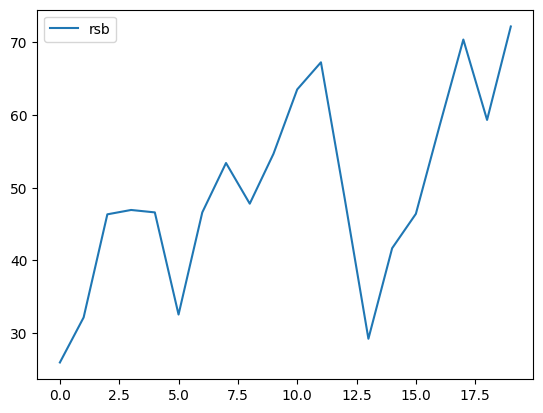

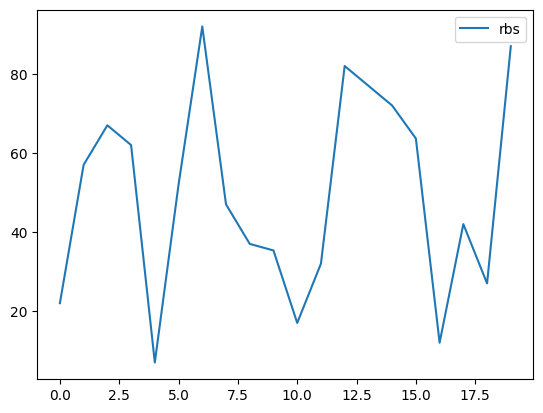

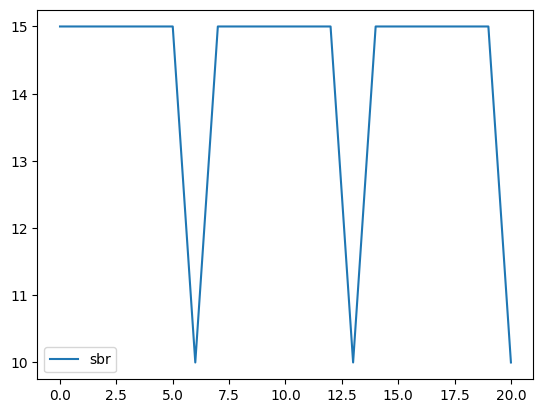

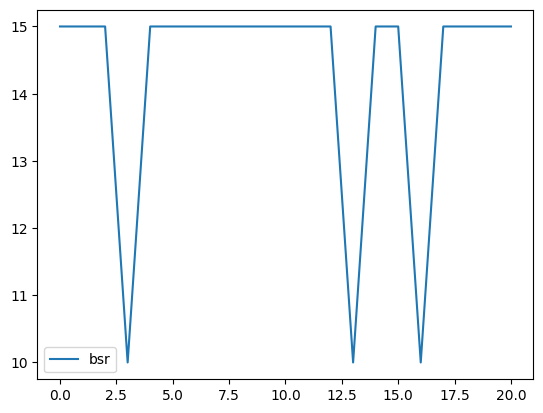

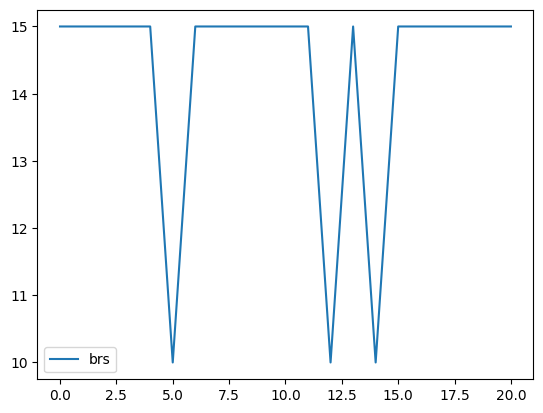

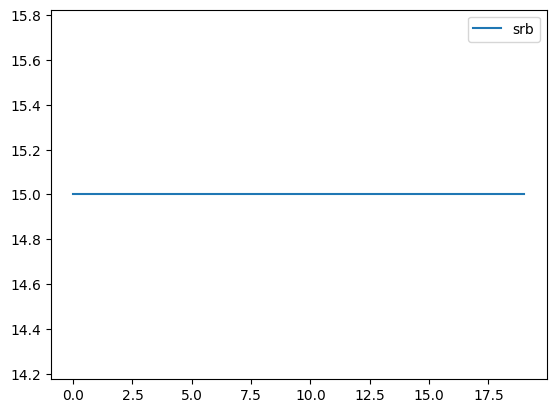

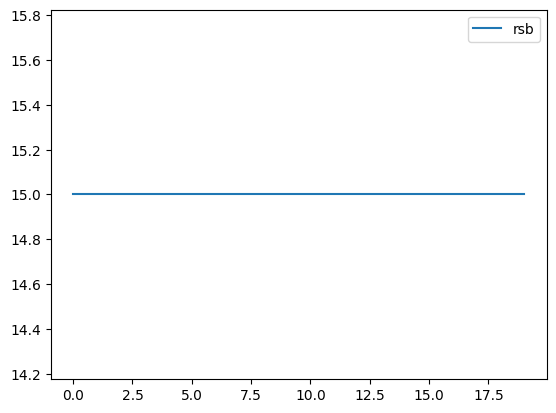

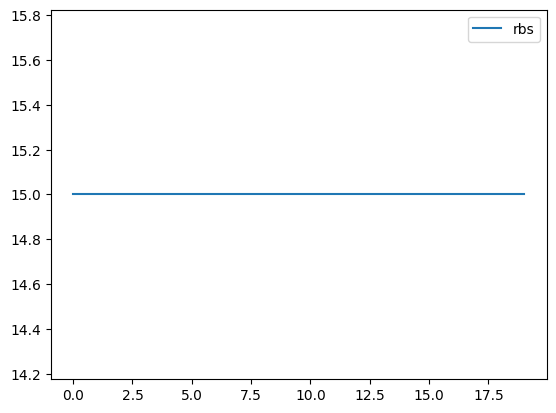

In [3]:
range_size = 100
buffer_size = 40
batch_size = 15
repeats = 3

rng_set = tf.data.Dataset.range(range_size)

sbr = [n.numpy().mean() for n in rng_set.shuffle(buffer_size).batch(batch_size).repeat(repeats)]
bsr = [n.numpy().mean() for n in rng_set.batch(batch_size).shuffle(buffer_size).repeat(repeats)]
brs = [n.numpy().mean() for n in rng_set.batch(batch_size).repeat(repeats).shuffle(buffer_size)]
srb = [n.numpy().mean() for n in rng_set.shuffle(buffer_size).repeat(repeats).batch(batch_size)]
rsb = [n.numpy().mean() for n in rng_set.repeat(repeats).shuffle(buffer_size).batch(batch_size)]
rbs = [n.numpy().mean() for n in rng_set.repeat(repeats).batch(batch_size).shuffle(buffer_size)]

plt.plot(sbr, label="sbr")
plt.legend()
plt.show()
plt.plot(bsr, label="bsr")
plt.legend()
plt.show()
plt.plot(brs, label="brs")
plt.legend()
plt.show()
plt.plot(srb, label="srb")
plt.legend()
plt.show()
plt.plot(rsb, label="rsb")
plt.legend()
plt.show()
plt.plot(rbs, label="rbs")
plt.legend()
plt.show()

sbr = [len(n.numpy()) for n in rng_set.shuffle(buffer_size).batch(batch_size).repeat(repeats)]
bsr = [len(n.numpy()) for n in rng_set.batch(batch_size).shuffle(buffer_size).repeat(repeats)]
brs = [len(n.numpy()) for n in rng_set.batch(batch_size).repeat(repeats).shuffle(buffer_size)]
srb = [len(n.numpy()) for n in rng_set.shuffle(buffer_size).repeat(repeats).batch(batch_size)]
rsb = [len(n.numpy()) for n in rng_set.repeat(repeats).shuffle(buffer_size).batch(batch_size)]
rbs = [len(n.numpy()) for n in rng_set.repeat(repeats).batch(batch_size).shuffle(buffer_size)]

plt.plot(sbr, label="sbr")
plt.legend()
plt.show()
plt.plot(bsr, label="bsr")
plt.legend()
plt.show()
plt.plot(brs, label="brs")
plt.legend()
plt.show()
plt.plot(srb, label="srb")
plt.legend()
plt.show()
plt.plot(rsb, label="rsb")
plt.legend()
plt.show()
plt.plot(rbs, label="rbs")
plt.legend()
plt.show()

In the diagrams above you can see the different effects of applying the 3 methods in different order.
- shuffle, batch, repeat: shuffle only shuffles the first 40 dates, batch splits this and repeat repeats this3 times
    - bad, because values of dates repeat in approximatly same order and batch sizes drops to 10, when not enough elements are left
- batch, shuffle, repeat: repeats approximatly every 3 batches, because batch_size 15 overflows buffer_size 40 after 3 steps
    - bad, but better than sbr
    - less elements in batch
- batch, repeat, shuffle: more random, but some repition, 
    - batch size not constant
- shuffle, repeat, batch: constant batch size, same repition as in sbr
- repeat, shuffle, batch: constant batch size, but kind of increasing values -> ordering of rng_set isn't destructed
- repeat, batch, shuffle: constant batch size, more random but looks like there is some order

**conclusion**: 
- repeat before batch to get constant batch size all the time
- shuffle before repeat not so nice
- shuffle befor batch seems to be better, because then the whole set is shuffled and batched instead of shuffling sorted batches

> *seemingly best order*: repeat().shuffle().batch()
>
> makes sense, since repeat() repeats the set, so we get constant batch sizes, then shuffle can shuffle the whole data set and batch can create the batches

### Using tf.data to load and batch MNIST

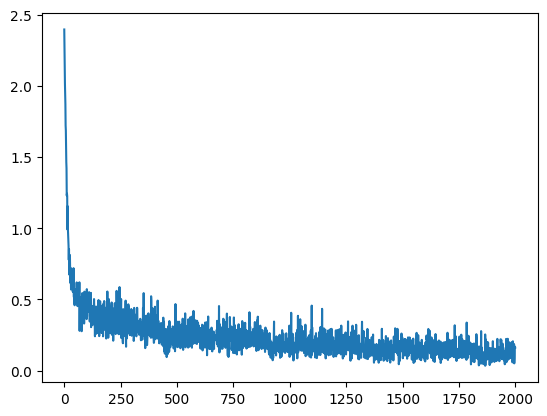

In [4]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# things we really gotta do:
# - normalize the images to [0, 1] (first convert to float)
# - reshape images from (28, 28) to (784,) (although we could do this later!)
# - convert labels to int32 (otherwise tensorflow is gonna be sad :( )

train_images = (train_images.astype(np.float32) / 255.).reshape((-1, 784))
test_images = (test_images.astype(np.float32) / 255.).reshape((-1, 784))

train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

# this is now different
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

train_data = train_data.repeat().shuffle(1152).batch(128)


# training...
mlp = MLP([784, 200, 10], 0.1)
xents = []
it = iter(train_data)

for _ in range(2000):
    imgs, lbls = next(it)
    xents.append(mlp.train(imgs, lbls, 0.2))
    
plt.plot(xents)
plt.show()

## First steps with TensorBoard

In [8]:
from datetime import datetime
import os

# set up log dir and file writer(s)
logdir = os.path.join("logs", "linear" + str(datetime.now()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))
test_writer = tf.summary.create_file_writer(os.path.join(logdir, "test"))


# re-doing mlp training with logs    
def train_with_logs(mlp, imgs, lbls, learning_rate, train_writer, test_writer, step):
    """returns the cross entropy error"""
    n = len(mlp.biases)

    with tf.GradientTape() as tape:
        logits = mlp.model(imgs)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbls))

    # log this stuff every time step (rather wasteful)
    with train_writer.as_default():
        tf.summary.scalar("loss", xent, step=step)
        tf.summary.histogram("logits", logits, step=step)
        for i in range(len(mlp.weights)):
            tf.summary.histogram("weights_" + str(i), mlp.weights[i], step=step)
    
        
    grads = tape.gradient(xent, mlp.weights + mlp.biases)
    for i in range(n):
        mlp.weights[i].assign_sub(learning_rate * grads[i])
        mlp.biases[i].assign_sub(learning_rate * grads[n+i])

    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, label_batch), tf.float32))
        
        # log this only once every 100 steps
        with train_writer.as_default():
            tf.summary.scalar("accuracy", acc, step=step)
            tf.summary.image("input", tf.reshape(image_batch, [-1, 28, 28, 1]), step=step)
            
        test_preds = tf.argmax(mlp.model(test_images), axis=1, output_type=tf.int32)
        test_acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, test_labels), tf.float32))
        with test_writer.as_default():
            tf.summary.scalar("accuracy", test_acc, step=step)
            
    
    return xent



In [13]:
mlp = MLP([784, 200, 10], 0.1)

it = iter(train_data)
for step, (image_batch, label_batch) in enumerate(train_data):
    if step > 2000:
        break
        
    imgs, lbls = next(it)
    train_with_logs(mlp, imgs, lbls, 0.2, train_writer, test_writer, step)

In [14]:
%load_ext tensorboard

In [15]:
%tensorboard --logdir logs

## Diagnosing Problems via Visualization
### Fail 1

In [5]:
"""copied fail1.py"""

#import tensorflow as tf
#import numpy as np


# get the data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()


def preprocess_images(images):
    return images.reshape(-1, 784).astype(np.float32) / 255


def preprocess_labels(labels):
    return labels.reshape(-1).astype(np.int32)


train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
train_labels = preprocess_labels(train_labels)
test_labels = preprocess_labels(test_labels)

train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(60000).batch(128).repeat()
#test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(128)


# define the model first, from input to output

# this is a super deep model, cool!
n_units = 100
n_layers = 8
w_range = 0.4

# just set up a "chain" of hidden layers
# model is represented by a list where each element is a layer,
# and each layer is in turn a list of the layer variables (w, b)

# first layer goes from n_input to n_hidden
w_input = tf.Variable(tf.random.uniform([784, n_units], -w_range, w_range),
                      name="w0")
b_input = tf.Variable(tf.zeros(n_units), name="b0")
layers = [[w_input, b_input]]

# all other hidden layers go from n_hidden to n_hidden
for layer in range(n_layers - 1):
    w = tf.Variable(tf.random.uniform([n_units, n_units], -w_range, w_range),
                    name="w" + str(layer+1))
    b = tf.Variable(tf.zeros(n_units), name="b" + str(layer+1))
    layers.append([w, b])

# finally add the output layer
w_out = tf.Variable(tf.random.uniform([n_units, 10], -w_range, w_range),
                    name="wout")
b_out = tf.Variable(tf.zeros(10), name="bout")
layers.append([w_out, b_out])

# flatten the layers to get a list of variables
all_variables = [variable for layer in layers for variable in layer]


def model_forward(inputs):
    x = inputs
    for w, b in layers[:-1]:
        x = tf.nn.relu(tf.matmul(x, w) + b)
    logits = tf.matmul(x, layers[-1][0]) + layers[-1][1]

    return logits


lr = 0.1
train_steps = 2000
for step, (img_batch, lbl_batch) in enumerate(train_data):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        # here we just run all the layers in sequence via a for-loop
        logits = model_forward(img_batch)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))

    grads = tape.gradient(xent, all_variables)
    for grad, var in zip(grads, all_variables):
        var.assign_sub(lr*grad)

    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))


test_preds = model_forward(test_images)
test_preds = tf.argmax(test_preds, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, test_labels), tf.float32))
print("Final test accuracy: {}".format(acc))


Loss: 173.986328125 Accuracy: 0.0546875
Loss: nan Accuracy: 0.1484375
Loss: nan Accuracy: 0.09375
Loss: nan Accuracy: 0.0859375
Loss: nan Accuracy: 0.1171875
Loss: nan Accuracy: 0.1171875
Loss: nan Accuracy: 0.1484375
Loss: nan Accuracy: 0.09375
Loss: nan Accuracy: 0.1015625
Loss: nan Accuracy: 0.09375
Loss: nan Accuracy: 0.078125
Loss: nan Accuracy: 0.09375
Loss: nan Accuracy: 0.09375
Loss: nan Accuracy: 0.0703125
Loss: nan Accuracy: 0.0859375
Loss: nan Accuracy: 0.1015625
Loss: nan Accuracy: 0.1015625
Loss: nan Accuracy: 0.0703125
Loss: nan Accuracy: 0.1015625
Loss: nan Accuracy: 0.078125
Loss: nan Accuracy: 0.078125
Final test accuracy: 0.09799999743700027


Loss is nan at some point.

-> **_Settign up logs with tensorboard_**

In [99]:
# set up log dir and file writer(s)
logdir = os.path.join("logs", "fail1" + str(datetime.now()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))
#test_writer = tf.summary.create_file_writer(os.path.join(logdir, "test"))

"""fail1.py with logs"""

# get the data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

def preprocess_images(images):
    return images.reshape(-1, 784).astype(np.float32) / 255

def preprocess_labels(labels):
    return labels.reshape(-1).astype(np.int32)

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
train_labels = preprocess_labels(train_labels)
test_labels = preprocess_labels(test_labels)

train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(60000).batch(128).repeat()
#test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(128)

# define the model first, from input to output

# this is a super deep model, cool!
n_units = 100
n_layers = 8
w_range = 0.1

# just set up a "chain" of hidden layers
# model is represented by a list where each element is a layer,
# and each layer is in turn a list of the layer variables (w, b)

# first layer goes from n_input to n_hidden
w_input = tf.Variable(tf.random.uniform([784, n_units], -w_range, w_range),
                      name="w0")
b_input = tf.Variable(tf.zeros(n_units), name="b0")
layers = [[w_input, b_input]]

# all other hidden layers go from n_hidden to n_hidden
for layer in range(n_layers - 1):
    w = tf.Variable(tf.random.uniform([n_units, n_units], -w_range, w_range),
                    name="w" + str(layer+1))
    b = tf.Variable(tf.zeros(n_units), name="b" + str(layer+1))
    layers.append([w, b])

# finally add the output layer
w_out = tf.Variable(tf.random.uniform([n_units, 10], -w_range, w_range),
                    name="wout")
b_out = tf.Variable(tf.zeros(10), name="bout")
layers.append([w_out, b_out])

# flatten the layers to get a list of variables
all_variables = [variable for layer in layers for variable in layer]


def model_forward(layers, inputs):
    x = inputs
    for w, b in layers[:-1]:
        x = tf.nn.relu(tf.matmul(x, w) + b)
        #print(x)
    logits = tf.matmul(x, layers[-1][0]) + layers[-1][1]

    return logits

In [51]:
all_variables

[<tf.Variable 'w0:0' shape=(784, 100) dtype=float32, numpy=
 array([[ 0.08668366, -0.29359245, -0.2159338 , ..., -0.10380632,
         -0.06194133, -0.25441134],
        [ 0.37150362,  0.0114336 , -0.13465768, ...,  0.09585303,
         -0.18120356, -0.10785419],
        [ 0.00436431, -0.37621394,  0.0812273 , ...,  0.11152849,
          0.36425403,  0.23159763],
        ...,
        [-0.14817446, -0.11257333, -0.28222972, ..., -0.3237521 ,
          0.05981502,  0.13471535],
        [-0.38716355,  0.21589431, -0.13503742, ..., -0.19531555,
          0.2426348 ,  0.16701481],
        [ 0.18658307,  0.3184081 , -0.24890566, ...,  0.2310603 ,
         -0.15017919,  0.3471755 ]], dtype=float32)>,
 <tf.Variable 'b0:0' shape=(100,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0

In [52]:
W,b = layers[0]
print(W)
print(b)

<tf.Variable 'w0:0' shape=(784, 100) dtype=float32, numpy=
array([[ 0.08668366, -0.29359245, -0.2159338 , ..., -0.10380632,
        -0.06194133, -0.25441134],
       [ 0.37150362,  0.0114336 , -0.13465768, ...,  0.09585303,
        -0.18120356, -0.10785419],
       [ 0.00436431, -0.37621394,  0.0812273 , ...,  0.11152849,
         0.36425403,  0.23159763],
       ...,
       [-0.14817446, -0.11257333, -0.28222972, ..., -0.3237521 ,
         0.05981502,  0.13471535],
       [-0.38716355,  0.21589431, -0.13503742, ..., -0.19531555,
         0.2426348 ,  0.16701481],
       [ 0.18658307,  0.3184081 , -0.24890566, ...,  0.2310603 ,
        -0.15017919,  0.3471755 ]], dtype=float32)>
<tf.Variable 'b0:0' shape=(100,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0

In [77]:
for img_batch, _ in train_data:
    logits = model_forward(layers, img_batch)
    break

In [100]:
lr = 0.1
train_steps = 2000
for step, (img_batch, lbl_batch) in enumerate(train_data):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        tape.watch(all_variables)
        # here we just run all the layers in sequence via a for-loop
        logits = model_forward(layers, img_batch)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))

    grads = tape.gradient(xent, all_variables)
    for grad, var in zip(grads, all_variables):
        var.assign_sub(lr*grad)
        
    with train_writer.as_default():
        tf.summary.scalar("loss", xent, step=step)
        tf.summary.histogram("logits", logits, step=step)
        #for v in all_variables:
        #    tf.summary.histogram(v.name, v, step=step)
    

    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        
        #with train_writer.as_default():
            #tf.summary.scalar("accuracy", acc, step=step)
            #tf.summary.image("input", tf.reshape(img_batch, [-1, 28, 28, 1]), step=step)
        
        print("Loss: {} Accuracy: {}".format(xent, acc))


test_preds = model_forward(layers, test_images)
test_preds = tf.argmax(test_preds, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, test_labels), tf.float32))
print("Final test accuracy: {}".format(acc))


Loss: 2.3025379180908203 Accuracy: 0.1328125
Loss: 2.2992899417877197 Accuracy: 0.140625
Loss: 2.2973289489746094 Accuracy: 0.140625
Loss: 2.3061184883117676 Accuracy: 0.046875
Loss: 2.2997570037841797 Accuracy: 0.125
Loss: 2.3030498027801514 Accuracy: 0.0859375
Loss: 2.299208641052246 Accuracy: 0.1171875
Loss: 2.3041462898254395 Accuracy: 0.0625
Loss: 2.2981321811676025 Accuracy: 0.0859375
Loss: 2.2978343963623047 Accuracy: 0.09375
Loss: 2.2803945541381836 Accuracy: 0.15625
Loss: 2.003000259399414 Accuracy: 0.203125
Loss: 1.6262041330337524 Accuracy: 0.390625
Loss: 1.1213154792785645 Accuracy: 0.4765625
Loss: 0.7065314650535583 Accuracy: 0.71875
Loss: 0.6121360063552856 Accuracy: 0.828125
Loss: 0.4528146982192993 Accuracy: 0.875
Loss: 0.33408159017562866 Accuracy: 0.9375
Loss: 0.33238890767097473 Accuracy: 0.8828125
Loss: 0.4459778368473053 Accuracy: 0.875
Loss: 0.2432149052619934 Accuracy: 0.9453125
Final test accuracy: 0.930400013923645


In [13]:
%load_ext tensorboard
%tensorboard --logdir logs --port 6007

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


__*Conclusions*__
- all biases and weights are NaN from the beginning
- gradients are not a number since the first iteration
- with tape.watch(all_variables) no more nan-weights in first iteration
- logits since iteration 0 Nan -> model_forward not working correctly
- logits become nan in step 3

### fail 2

In [96]:
# set up log dir and file writer(s)
logdir = os.path.join("logs", "fail2" + str(datetime.now()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))
#test_writer = tf.summary.create_file_writer(os.path.join(logdir, "test"))

"""====================="""

# get the data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()


def preprocess_images(images):
    return images.reshape(-1, 784).astype(np.float32) / 255


def preprocess_labels(labels):
    return labels.reshape(-1).astype(np.int32)


train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
train_labels = preprocess_labels(train_labels)
test_labels = preprocess_labels(test_labels)

train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(60000).batch(128).repeat()
#test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(128)


# define the model first, from input to output

# this is a super deep model, cool!
n_units = 100
n_layers = 8
w_range = 0.1

# just set up a "chain" of hidden layers
# model is represented by a list where each element is a layer,
# and each layer is in turn a list of the layer variables (w, b)

# first layer goes from n_input to n_hidden
w_input = tf.Variable(tf.random.uniform([784, n_units], -w_range, w_range),
                      name="w0")
b_input = tf.Variable(tf.zeros(n_units), name="b0")
layers = [[w_input, b_input]]

# all other hidden layers go from n_hidden to n_hidden
for layer in range(n_layers - 1):
    w = tf.Variable(tf.random.uniform([n_units, n_units], -w_range, w_range),
                    name="w" + str(layer+1))
    b = tf.Variable(tf.zeros(n_units), name="b" + str(layer+1))
    layers.append([w, b])

# finally add the output layer
w_out = tf.Variable(tf.random.uniform([n_units, 10], -w_range, w_range),
                    name="wout")
b_out = tf.Variable(tf.zeros(10), name="bout")
layers.append([w_out, b_out])

# flatten the layers to get a list of variables
all_variables = [variable for layer in layers for variable in layer]


def model_forward(inputs):
    x = inputs
    for w, b in layers[:-1]:
        x = tf.nn.sigmoid(tf.matmul(x, w) + b,)
    logits = tf.matmul(x, layers[-1][0]) + layers[-1][1]

    return logits


lr = 0.1
train_steps = 2000
for step, (img_batch, lbl_batch) in enumerate(train_data):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        # here we just run all the layers in sequence via a for-loop
        logits = model_forward(img_batch)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=lbl_batch))

    grads = tape.gradient(xent, all_variables)
    for grad, var in zip(grads, all_variables):
        var.assign_sub(lr*grad)
        
    with train_writer.as_default():
        tf.summary.histogram("logits", logits, step=step)
        tf.summary.scalar("loss", xent, step=step)
        for w, _ in layers:
            tf.summary.histogram(w.name, w, step=step)

    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch), tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))


test_preds = model_forward(test_images)
test_preds = tf.argmax(test_preds, axis=1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, test_labels), tf.float32))
print("Final test accuracy: {}".format(acc))


Loss: 2.3193864822387695 Accuracy: 0.109375
Loss: 2.312174081802368 Accuracy: 0.0859375
Loss: 2.3120648860931396 Accuracy: 0.09375
Loss: 2.3037588596343994 Accuracy: 0.140625
Loss: 2.3113746643066406 Accuracy: 0.109375
Loss: 2.3028340339660645 Accuracy: 0.1171875
Loss: 2.3082656860351562 Accuracy: 0.0859375
Loss: 2.315028190612793 Accuracy: 0.0859375
Loss: 2.299384593963623 Accuracy: 0.140625
Loss: 2.3358914852142334 Accuracy: 0.078125
Loss: 2.3101274967193604 Accuracy: 0.0703125
Loss: 2.301891803741455 Accuracy: 0.09375
Loss: 2.3040475845336914 Accuracy: 0.125
Loss: 2.300421953201294 Accuracy: 0.1171875
Loss: 2.312357187271118 Accuracy: 0.0703125
Loss: 2.2884106636047363 Accuracy: 0.1484375
Loss: 2.3191895484924316 Accuracy: 0.109375
Loss: 2.303497791290283 Accuracy: 0.109375
Loss: 2.3175458908081055 Accuracy: 0.1015625
Loss: 2.291477680206299 Accuracy: 0.109375
Loss: 2.2942392826080322 Accuracy: 0.125
Final test accuracy: 0.11349999904632568


_**Conclusion**_
- logits are totally random
- weights are uniformly distributed and cut away on -w_range and w_range
- implies that gradient descent isn't working -> vanishing gradient because of sigmoid (?)
- (leaky) relu even worse than sigmoid
- less layers don't fix randomness

### Fail 3
- initialization with negative values only
- relu again instead of sigmoid

### Fail 4
- initialization with -w_range, w_range again
- but adding noise on image_batch... stddev=4 -> _**pixel_values can be negative quite easily**_

### Fail 5
- no more noise
- logits with sofmax-activation -> _**makes no sense with using sparse_softmax_cross_entropy_with_logits**_


## Conclusion on all Fails

**Fail 1**
- w_range was to high with 0.4 so values where exploding -> w_range = 0.1 works fine

**Fail 2**
- sigmoid is bad for this because of vanishing gradient

**Fail 3**
- initialization with negative values only and relu -> no learning

**Fail 4**
- noise is way to high (and unnecessary) -> negative pixel values are created
- and noise not for input layer but in hidden layers

**Fail 5**
- softmax makes no sense for calculating the logits -> don't use this